-----------
Initializing structure...
time for choose_chunkdivision = 0.00123096 s
Working in 3D dimensions.
Computational cell is 50 x 17.2 x 10 with resolution 5
     cylinder, center = (0,0,0)
          radius 3.5, height 0.2, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,3.69,0)
          size (40,0.22,0.1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-3.69,0)
          size (40,0.22,0.1)
          axes (1,0,0), (0,1,0), (0,0,1)


          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 6.09565 s
-----------
on time step 1 (time=0.1), 5.21381 s/step
on time step 60 (time=6), 0.0692017 s/step
on time step 116 (time=11.6), 0.0717501 s/step
on time step 172 (time=17.2), 0.0720766 s/step
on time step 225 (time=22.5), 0.0756962 s/step
on time step 283 (time=28.3), 0.0701174 s/step
on time step 344 (time=34.4), 0.0658455 s/step
on time step 400 (time=40), 0.0727901 s/step
on time step 459 (time=45.9), 0.0684729 s/step
field decay(t = 50.1): 5.91051293652872e-13 / 5.91051293652872e-13 = 1.0
on time step 510 (time=51), 0.0786075 s/step
on time step 558 (time=55.8), 0.083564 s/step
on time step 613 (time=61.3), 0.0731173 s/step
on time step 658 (time=65.8), 0.0890927 s/step
on time step 695 (time=69.5), 0.109543 s/step
on time step 737 (time=73.7), 0.0952599 s/step
on time step 768 (time=76.8), 0.129259 s/step
on time step 793 (time=79.3), 0.163627 s/step
on time step 816 (time=81.6), 0.181617 s

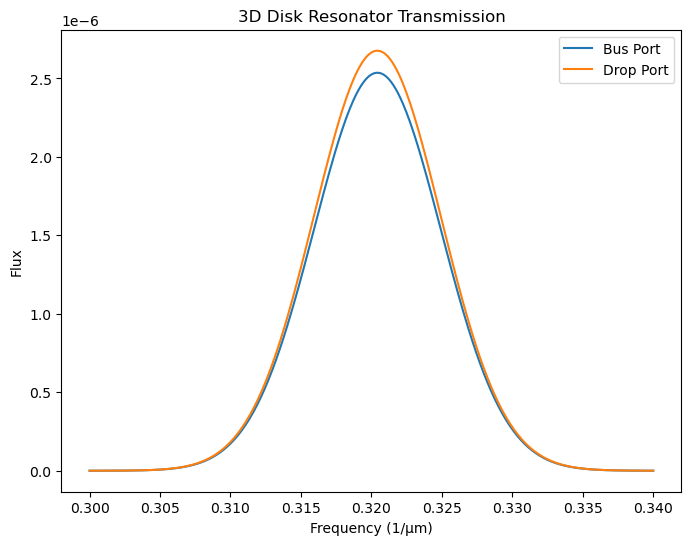

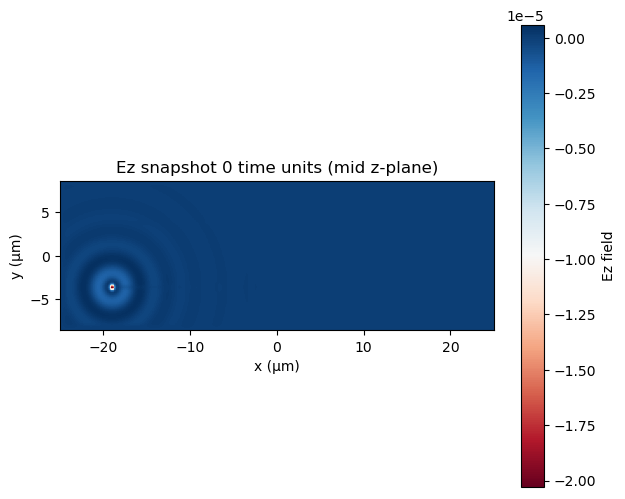

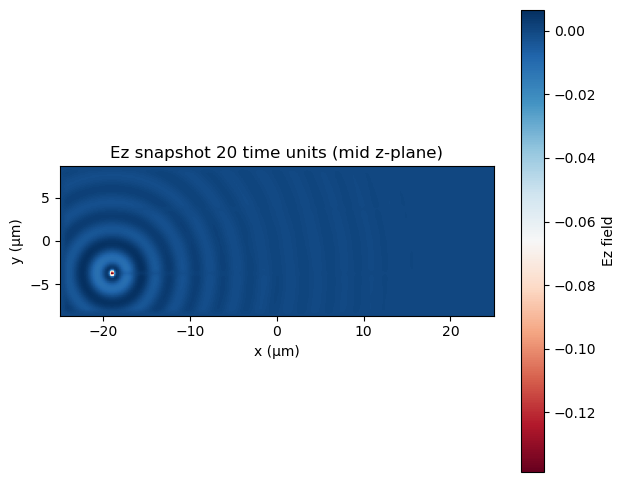

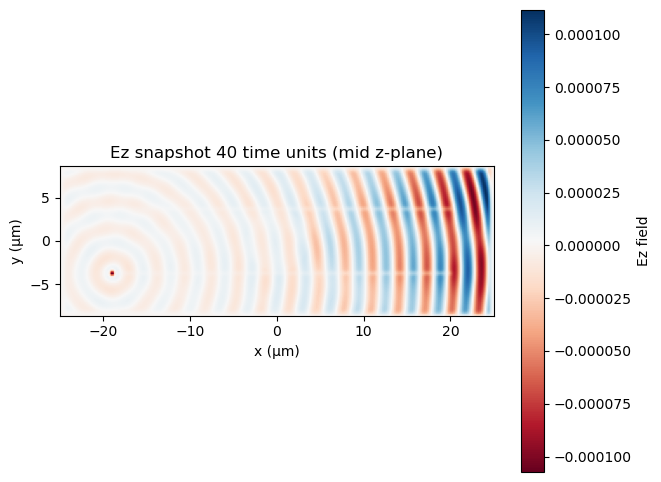

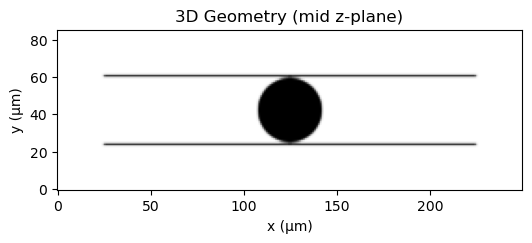

In [3]:
import meep as mp
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# Simulation parameters
# -----------------------------
resolution = 5  # pixels/um

# Materials
gaas = mp.Medium(epsilon=12)

# Disk and waveguide geometry
disk_radius = 3.5     # um
disk_height = 0.2     # um
wg_length = 40        # um
wg_width = 0.22       # um
wg_height = 0.1       # um
gap = 0.08            # distance between disk and waveguides

# Simulation cell size (make sure divisible by resolution)
cell_x = int((wg_length + 10) * resolution) / resolution
cell_y = int((2*(disk_radius + gap + wg_width/2) + 10) * resolution) / resolution
cell_z = 10.0           # enough space above and below disk

cell = mp.Vector3(cell_x, cell_y, cell_z)

# PML layers
pml_layers = [mp.PML(1.0)]

# -----------------------------
# Geometry
# -----------------------------
geometry = [
    # Disk resonator
    mp.Cylinder(radius=disk_radius, height=disk_height, center=mp.Vector3(), material=gaas),

    # Top bus waveguide
    mp.Block(size=mp.Vector3(wg_length, wg_width, wg_height),
             center=mp.Vector3(0, disk_radius + gap + wg_width/2, 0),
             material=gaas),

    # Bottom drop waveguide
    mp.Block(size=mp.Vector3(wg_length, wg_width, wg_height),
             center=mp.Vector3(0, -disk_radius - gap - wg_width/2, 0),
             material=gaas)
]

# -----------------------------
# Source
# -----------------------------
source_x = -wg_length/2 + 1
source_y = disk_radius + gap + wg_width/2
source_z = 0

fmin = 0.3   # 1/um
fmax = 0.34
fcen = (fmin+fmax)/2
df = fmax - fmin
nfreq = 300

sources = [mp.Source(mp.GaussianSource(frequency=fcen, fwidth=df),
                     component=mp.Ez,
                     center=mp.Vector3(source_x, source_y, source_z),
                     size=mp.Vector3(0, wg_width, wg_height))]

# -----------------------------
# Flux monitors
# -----------------------------
flux_region_bus = mp.FluxRegion(center=mp.Vector3(wg_length/2 - 1, disk_radius + gap + wg_width/2, 0),
                                size=mp.Vector3(0, wg_width, wg_height))

flux_region_drop = mp.FluxRegion(center=mp.Vector3(wg_length/2 - 1, -disk_radius - gap - wg_width/2, 0),
                                 size=mp.Vector3(0, wg_width, wg_height))

# -----------------------------
# Simulation
# -----------------------------
sim = mp.Simulation(cell_size=cell,
                    geometry=geometry,
                    sources=sources,
                    boundary_layers=pml_layers,
                    resolution=resolution,
                    dimensions=3)

flux_bus = sim.add_flux(fcen, df, nfreq, flux_region_bus)
flux_drop = sim.add_flux(fcen, df, nfreq, flux_region_drop)

# -----------------------------
# Store Ez snapshots
# -----------------------------
ez_data = []

def store_fields(sim):
    ez_data.append(sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez))

# Run simulation with snapshots
sim.run(mp.at_every(20, store_fields),
        until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0,0,0), 1e-3))

# -----------------------------
# Extract flux spectra
# -----------------------------
frequencies = np.array(mp.get_flux_freqs(flux_bus))
flux_bus_data = np.array(mp.get_fluxes(flux_bus))
flux_drop_data = np.array(mp.get_fluxes(flux_drop))

# -----------------------------
# Plot transmission spectra
# -----------------------------
plt.figure(figsize=(8,6))
plt.plot(frequencies, flux_bus_data, label="Bus Port")
plt.plot(frequencies, flux_drop_data, label="Drop Port")
plt.xlabel("Frequency (1/µm)")
plt.ylabel("Flux")
plt.title("3D Disk Resonator Transmission")
plt.legend()
plt.show()

# -----------------------------
# Plot Ez snapshots (mid z-plane)
# -----------------------------
mid_z_idx = int(cell_z/2 * resolution)  # index for mid-plane

for i, field in enumerate(ez_data[::5]):  # every 5th snapshot
    plt.figure(figsize=(7,6))
    plt.imshow(np.rot90(field[:,:,mid_z_idx]), cmap="RdBu", origin="lower",
               extent=[-cell_x/2, cell_x/2, -cell_y/2, cell_y/2])
    plt.colorbar(label="Ez field")
    plt.title(f"Ez snapshot {i*20} time units (mid z-plane)")
    plt.xlabel("x (µm)")
    plt.ylabel("y (µm)")
    plt.show()

# -----------------------------
# Plot geometry (mid z-plane)
# -----------------------------
eps = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)
plt.figure(figsize=(6,6))
plt.imshow(np.rot90(eps[:,:,mid_z_idx]), origin='lower', cmap='Greys')
plt.title("3D Geometry (mid z-plane)")
plt.xlabel("x (µm)")
plt.ylabel("y (µm)")
plt.show()


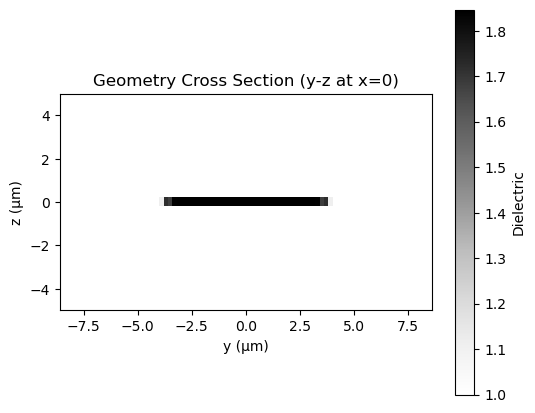

In [ ]:
2
5
2
2
2
2
2
2
2
2